In [1]:
%%time
import tensorflow as tf
from numba import cuda
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import pickle
from keras.layers import Dense, Input, Dropout
from keras import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import keras
print(keras.__version__)
from sklearn.model_selection import train_test_split
from keras.constraints import maxnorm
import numpy as np
from sklearn.metrics import roc_auc_score
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D ,Activation
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Flatten, MaxPooling1D, Input, Concatenate, Activation, Reshape,Conv2D
from keras.layers.merge import concatenate
from keras.models import Model

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 187090073553270580
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9978519113059827060
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 17966617097444840264
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15870492672
locality {
  bus_id: 1
  links {
  }
}
incarnation: 156751183658518359
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


Using TensorFlow backend.


2.3.1
CPU times: user 4.63 s, sys: 1.33 s, total: 5.97 s
Wall time: 13.8 s


In [2]:
def plot_history(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    auc = history.history['auc']
    val_auc = history.history['val_auc']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.plot(x, accuracy, 'b', label='Training accuracy')
    plt.plot(x, val_accuracy, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 3, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.subplot(1, 3, 3)
    plt.plot(x, auc, 'b', label='Training auc')
    plt.plot(x, val_auc, 'r', label='Validation auc')
    plt.title('Training and validation auc')
    plt.legend()

In [3]:
%%time
# preprocessing
with open(r"../input/challengedadata/comments.txt", "rb") as f:
    clean_train_comments = pickle.load(f) 
    f.close()

with open(r"../input/challengedadata/targets.txt", "rb") as ft:
    y= pickle.load(ft) 
    ft.close()

    
y = [int(s) for s in y]


# model1 suggested parameters
max_features = 5000
maxlen = 400
#
clean_train,clean_valid,y_train,y_valid = train_test_split(clean_train_comments,y, train_size = 0.8, test_size = 0.2, random_state = 0)


#tfidf vectorization
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english', max_features =max_features )


# We transform each complaint into a vector
print("training tfidf and vectorizing train")
X_train = tfidf.fit_transform(clean_train).toarray() #clean-train_comments # as this: https://stats.stackexchange.com/questions/154660/tfidfvectorizer-should-it-be-used-on-train-only-or-traintest   and this: https://stackoverflow.com/questions/47778403/computing-tf-idf-on-the-whole-dataset-or-only-on-training-data suggest,train tfidf only on training set
X_valid = tfidf.transform(clean_valid).toarray()
vocab_size = len(tfidf.vocabulary_) + 1
print("vocab_size = ", vocab_size)
print("evaluating maxlen")
# evaluate max len train data
maxlen_train = max([len(x) for x in X_train])
# pad train data accordingly
print("padding")
X_train_pad =  pad_sequences(X_train, padding='post', maxlen=maxlen, dtype='float32')  #maxlen_train
#train scaler
print("training scaler and scaling train")
scaler = StandardScaler(with_mean=False)
X_train_pad_scal = scaler.fit_transform(X_train_pad)
print("preparing validation set. padding...")
X_valid_pad = pad_sequences(X_valid, padding='post', maxlen=maxlen, dtype='float32') #maxlen_train 
print("scaling...")
X_valid_pad_scal = scaler.transform(X_valid_pad)
# # end of tfidf vectorization

# keras tokenization
# print("keras tokenizing")
# tokenizer = Tokenizer(num_words=5000)
# tokenizer.fit_on_texts(clean_train)
# print("keras trasforming")
# X_train = tokenizer.texts_to_sequences(clean_train)
# X_valid = tokenizer.texts_to_sequences(clean_valid)
# vocab_size = len(tokenizer.word_index) + 1 
# maxlen = 400
# print("keras padding")
# X_train_pad =  pad_sequences(X_train, padding='post', maxlen=maxlen, dtype='float32')  #maxlen_train
# X_valid_pad = pad_sequences(X_valid, padding='post', maxlen=maxlen, dtype='float32') #maxlen_train 
# # end of keras tokenization


training tfidf and vectorizing train
vocab_size =  5001
evaluating maxlen
padding
training scaler and scaling train
preparing validation set. padding...
scaling...
CPU times: user 31.8 s, sys: 745 ms, total: 32.5 s
Wall time: 32.6 s


In [4]:
print(vocab_size)

5001


In [5]:
# Define the models.

METRICS = [ tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.AUC(name='auc')]

    
def model1():  #0.8 from
    max_features = 5000
    maxlen = 400
    batch_size = 32
    embedding_dims = 150 #50
    filters = 400 #250
    kernel_size = 5 #3
    hidden_dims = 250
    epochs = 2
        
    model = Sequential()

    # we start off with an efficient embedding layer which maps
    # our vocab indices into embedding_dims dimensions
    model.add(Embedding(max_features,
                        embedding_dims,
                        input_length=maxlen))
    model.add(Dropout(0.1)) #0.2

    # we add a Convolution1D, which will learn filters
    # word group filters of size filter_length:
    model.add(Conv1D(filters,
                     kernel_size,
                     padding='valid',
                     activation='relu',
                     strides=1)) #1
    # we use max pooling:
    model.add(GlobalMaxPooling1D())

    # We add a vanilla hidden layer:
    model.add(Dense(hidden_dims))
    model.add(Dropout(0.1)) #0.2
    model.add(Activation('relu'))

    # We project onto a single unit output layer, and squash it with a sigmoid:
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=METRICS)


    return model


def model2():  #0.78
    embedding_dim = 300
    maxlen = 400
    model = Sequential()
    model.add(layers.Embedding(input_dim=vocab_size, 
                               output_dim=embedding_dim, 
                               input_length=maxlen))
    model.add(layers.GlobalMaxPool1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=METRICS)
    return model


def model7():
    maxlen = 400
    embedding_dim = 300
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(Conv1D(512, 3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2)) #0.5
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=METRICS)
    return model

def model8(): #0.73
#     def define_model(length, vocab_size):
    # channel 1
    maxlen = 400
    embedding_dim = 300
    inputs1 = Input(shape=(maxlen,))
    embedding1 = Embedding(vocab_size, 300)(inputs1) #100
    conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
    drop1 = Dropout(0.2)(conv1) #0.5
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)
    # channel 2
    inputs2 = Input(shape=(maxlen,))
    embedding2 = Embedding(vocab_size, 300)(inputs2) #100
    conv2 = Conv1D(filters=32, kernel_size=6, activation='relu')(embedding2)
    drop2 = Dropout(0.2)(conv2) #0.5
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2 = Flatten()(pool2)
    # channel 3
    inputs3 = Input(shape=(maxlen,))
    embedding3 = Embedding(vocab_size, 300)(inputs3) #100
    conv3 = Conv1D(filters=32, kernel_size=8, activation='relu')(embedding3)
    drop3 = Dropout(0.2)(conv3) #0.5
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)
    # merge
    merged = concatenate([flat1, flat2, flat3])
    # interpretation
    dense1 = Dense(10, activation='relu')(merged)
    outputs = Dense(1, activation='sigmoid')(dense1)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    # compile
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=METRICS)
    # summarize
    #print(model.summary())
    #plot_model(model, show_shapes=True, to_file='multichannel.png')
    return model

In [6]:
# callbacks
class MyCustomCallback1(tf.keras.callbacks.Callback):
  
    def on_epoch_end(self,epoch, logs=None):
        y_pred = model1.predict_proba(X_valid_pad)
        print("roc evaluated with scikit = ",roc_auc_score(y_valid, y_pred))
        return
    
class MyCustomCallback2(tf.keras.callbacks.Callback):
  
    def on_epoch_end(self,epoch, logs=None):
        y_pred = model2.predict(X_valid_pad)
        print("roc evaluated with scikit = ",roc_auc_score(y_valid, y_pred))
        return

    
class MyCustomCallback7(tf.keras.callbacks.Callback):
  
    def on_epoch_end(self,epoch, logs=None):
        y_pred = model7.predict_proba(X_valid_pad)
        print("roc evaluated with scikit = ",roc_auc_score(y_valid, y_pred))
        return
    

MODEL1


/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4000 samples, validate on 1000 samples
Epoch 1/4
4000/4000 [==============================] - 9s 2ms/step - loss: 0.5918 - accuracy: 0.7250 - auc: 0.4840 - val_loss: 0.5855 - val_accuracy: 0.7276 - val_auc: 0.4954
roc evaluated with scikit =  0.4977826033765599
Epoch 2/4
4000/4000 [==============================] - 5s 1ms/step - loss: 0.5887 - accuracy: 0.7319 - auc: 0.4963 - val_loss: 0.5816 - val_accuracy: 0.7290 - val_auc: 0.5006
roc evaluated with scikit =  0.498134328358209
Epoch 3/4
4000/4000 [==============================] - 4s 1ms/step - loss: 0.5897 - accuracy: 0.7303 - auc: 0.5013 - val_loss: 0.5857 - val_accuracy: 0.7294 - val_auc: 0.5002
roc evaluated with scikit =  0.4977826033765599
Epoch 4/4
4000/4000 [==============================] - 4s 1ms/step - loss: 0.5865 - accuracy: 0.7299 - auc: 0.4992 - val_loss: 0.5824 - val_accuracy: 0.7296 - val_auc: 0.4979
roc evaluated with scikit =  0.4977826033765599
MODEL2


/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4000 samples, validate on 1000 samples
Epoch 1/4
4000/4000 [==============================] - 4s 883us/step - loss: 0.5884 - accuracy: 0.7303 - auc: 0.4983 - val_loss: 0.5844 - val_accuracy: 0.7297 - val_auc: 0.4973
roc evaluated with scikit =  0.5018656716417911
Epoch 2/4
4000/4000 [==============================] - 3s 750us/step - loss: 0.5854 - accuracy: 0.7301 - auc: 0.4976 - val_loss: 0.5818 - val_accuracy: 0.7298 - val_auc: 0.4978
roc evaluated with scikit =  0.498134328358209
Epoch 3/4
4000/4000 [==============================] - 3s 776us/step - loss: 0.5852 - accuracy: 0.7304 - auc: 0.4973 - val_loss: 0.5871 - val_accuracy: 0.7299 - val_auc: 0.4977
roc evaluated with scikit =  0.498134328358209
Epoch 4/4
4000/4000 [==============================] - 3s 776us/step - loss: 0.5850 - accuracy: 0.7300 - auc: 0.4972 - val_loss: 0.5815 - val_accuracy: 0.7299 - val_auc: 0.4969
roc evaluated with scikit =  0.498134328358209
MODEL7


/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4000 samples, validate on 1000 samples
Epoch 1/4
4000/4000 [==============================] - 5s 1ms/step - loss: 0.5909 - accuracy: 0.7301 - auc: 0.4975 - val_loss: 0.5862 - val_accuracy: 0.7298 - val_auc: 0.4980
roc evaluated with scikit =  0.498134328358209
Epoch 2/4
4000/4000 [==============================] - 5s 1ms/step - loss: 0.5909 - accuracy: 0.7298 - auc: 0.4977 - val_loss: 0.5831 - val_accuracy: 0.7298 - val_auc: 0.4975
roc evaluated with scikit =  0.498134328358209
Epoch 3/4
4000/4000 [==============================] - 5s 1ms/step - loss: 0.5847 - accuracy: 0.7301 - auc: 0.4993 - val_loss: 0.5820 - val_accuracy: 0.7298 - val_auc: 0.5006
roc evaluated with scikit =  0.498134328358209
Epoch 4/4
4000/4000 [==============================] - 5s 1ms/step - loss: 0.5885 - accuracy: 0.7301 - auc: 0.5005 - val_loss: 0.5831 - val_accuracy: 0.7299 - val_auc: 0.5003
roc evaluated with scikit =  0.498134328358209
MODEL8


/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/4
4000/4000 [==============================] - 4s 1ms/step - loss: 0.5962 - accuracy: 0.7301 - auc: 0.5001
Epoch 2/4
4000/4000 [==============================] - 3s 845us/step - loss: 0.5894 - accuracy: 0.7300 - auc: 0.5001
Epoch 3/4
4000/4000 [==============================] - 4s 991us/step - loss: 0.5870 - accuracy: 0.7302 - auc: 0.5002
Epoch 4/4
1000/1000 [==============================] - 0s 352us/step


[0.5983215699195862, 0.7298775911331177, 0.50021892786026]

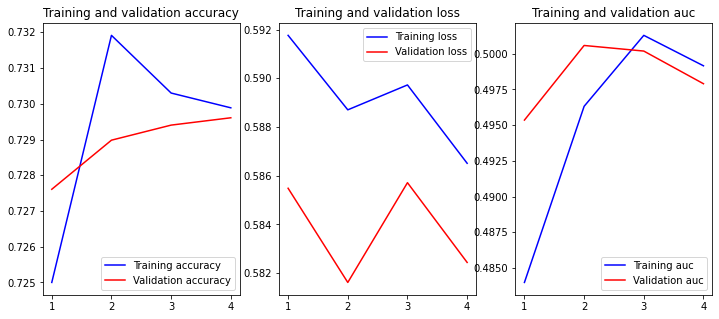

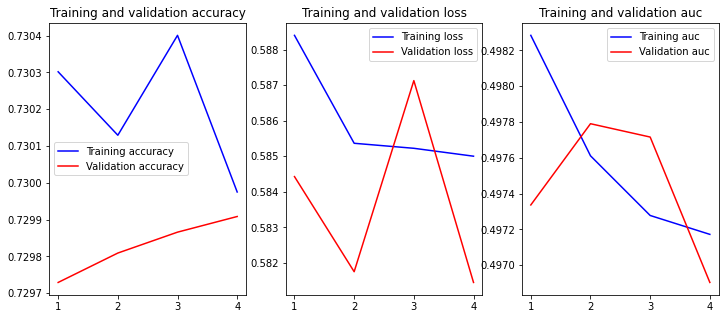

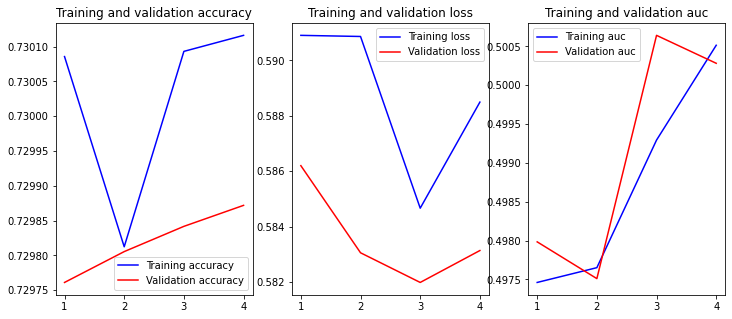

In [7]:
# early stopping

callbacks = EarlyStopping(
        monitor='val_loss', # val_accuracy
        min_delta=1e-2,
        patience=2, #2
        verbose=10)


print("MODEL1")
model1 = model1()
history1 = model1.fit(x=X_train_pad, y=y_train, batch_size = 8, epochs = 4, verbose=1,validation_data = (X_valid_pad,y_valid), callbacks=[MyCustomCallback1()], shuffle=True, validation_freq=1, max_queue_size=10, workers=4, use_multiprocessing=True) #, callbacks=callbacks , validation_split=0.2
plot_history(history1)

print("MODEL2")
model2 = model2()
history2 = model2.fit(x=X_train_pad, y=y_train, batch_size = 8, epochs = 4, verbose=1,validation_data = (X_valid_pad,y_valid), callbacks=[MyCustomCallback2()], shuffle=True, validation_freq=1, max_queue_size=10, workers=4, use_multiprocessing=True) #, callbacks=callbacks , validation_split=0.2
plot_history(history2)

print("MODEL7")
model7 = model7()
history7 = model7.fit(x=X_train_pad, y=y_train, batch_size = 8, epochs = 4, verbose=1,validation_data = (X_valid_pad,y_valid), callbacks=[MyCustomCallback7()], shuffle=True, validation_freq=1, max_queue_size=10, workers=4, use_multiprocessing=True) #, callbacks=callbacks , validation_split=0.2
plot_history(history7)

print("MODEL8")
model8 = model8()
history8 = model8.fit([X_train_pad,X_train_pad,X_train_pad], np.array(y_train), epochs=4, batch_size=16)
#plot_history(history8)
model8.evaluate([X_valid_pad,X_valid_pad,X_valid_pad], np.array(y_valid))
# reset gpu memory https://stackoverflow.com/a/60354785/13110508 (but be warned: it crashes python, so use it just at the end)
# device = cuda.get_current_device()
# device.reset()